In [1]:
%load_ext autoreload  
%autoreload 2  
!hostname  
!pwd  
import os, sys
print(sys.executable)
# os.environ['CUDA_VISIBLE_DEVICES'] = "7"

dhcp-10-31-130-63.dyn.MIT.EDU
/Users/akarshkumar0101/ml-ideas
/Users/akarshkumar0101/miniconda3/bin/python


In [2]:
import os, sys, glob, pickle
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat


In [3]:

import jax
import jax.numpy as jnp
from jax.random import split

import flax
import flax.linen as nn
from flax.training.train_state import TrainState

import optax


In [157]:
# https://www.youtube.com/watch?v=scvuli-zcRc&t=3s

In [158]:
n_particles = 1000
n_colors = 8
n_dims = 2

dt = 0.02
half_life = 0.04
rmax = 0.1

def init_env_params(rng):
    beta = 0.3
    alphas = jax.random.uniform(rng, (n_colors, n_colors), minval=-1, maxval=1)
    return dict(alphas=alphas, beta=beta)

def calc_force(r, alpha, beta):
    first = r / beta - 1
    second = alpha * (1 - jnp.abs(2 * r - 1 - beta) / (1 - beta))
    cond_first = (0 < r) & (r < beta)
    cond_second = (beta < r) & (r < 1)
    return jnp.where(cond_first, first, jnp.where(cond_second, second, 0.))

def init_state(rng):
    rng, _rng = split(rng)
    x = jax.random.uniform(_rng, (n_particles, n_dims), minval=-1, maxval=1)
    v = jnp.zeros((n_particles, n_dims))
    rng, _rng = split(rng)
    c = jax.random.randint(_rng, (n_particles,), 0, n_colors)
    return dict(x=x, v=v, c=c)

@jax.jit
def forward_state(rng, state, env_params):
    x, v, c = state['x'], state['v'], state['c']
    alphas, beta = env_params['alphas'], env_params['beta']

    alpha = alphas[c[:, None], c[None, :]]
    r = x[:, None, :] - x[None, :, :]
    rlen = jnp.linalg.norm(r, axis=-1)
    
    f = jax.vmap(jax.vmap(partial(calc_force, beta=beta)))(rlen/rmax, alpha)
    f = rmax * r/rlen[..., None] * f[..., None]
    f = f.at[jnp.arange(n_particles), jnp.arange(n_particles)].set(0.)
    f = jnp.sum(f, axis=0)
    acc = f * 10.
    
    mu = (.5) ** (dt / half_life)
    v = mu * v + acc * dt
    x = x + v * dt
    return dict(x=x, v=v, c=c)

def render_state(state):
    x, v, c = state['x'], state['v'], state['c']
    for ci in range(n_colors):
        plt.scatter(*x[c==ci].T, s=1.)
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)


  0%|          | 0/1000 [00:00<?, ?it/s]

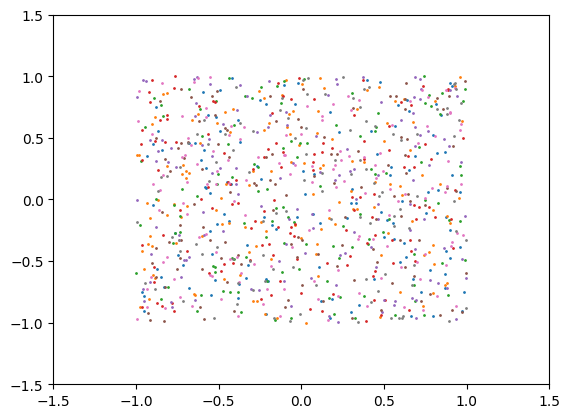

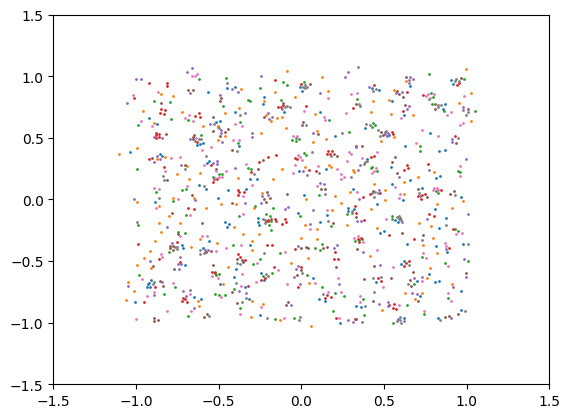

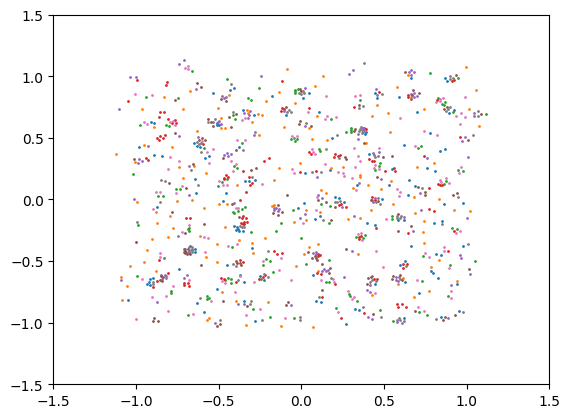

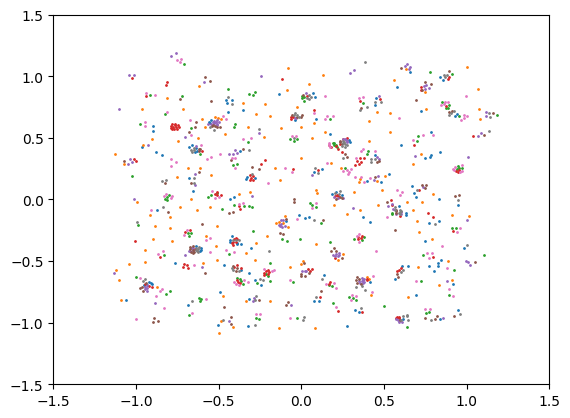

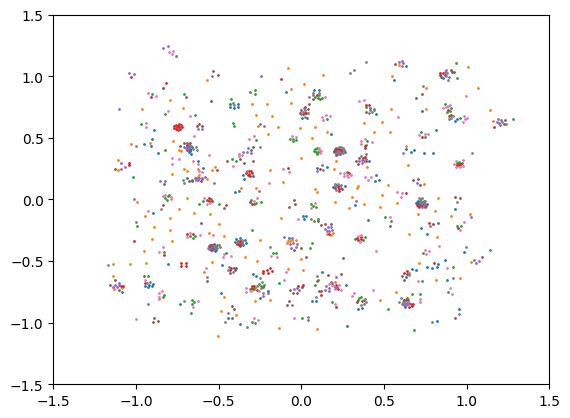

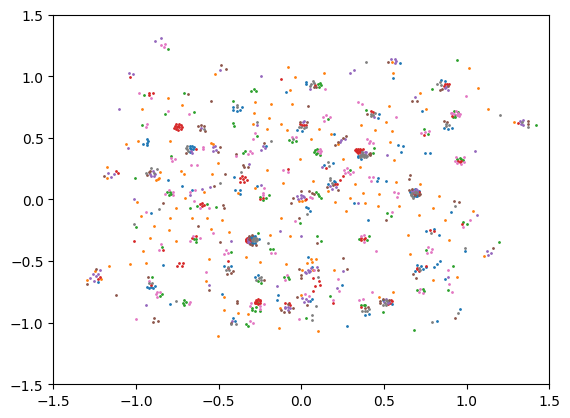

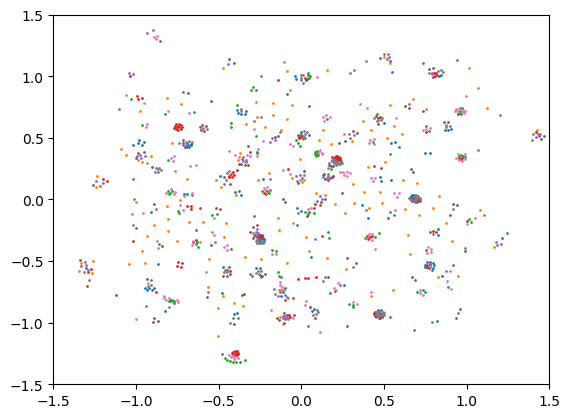

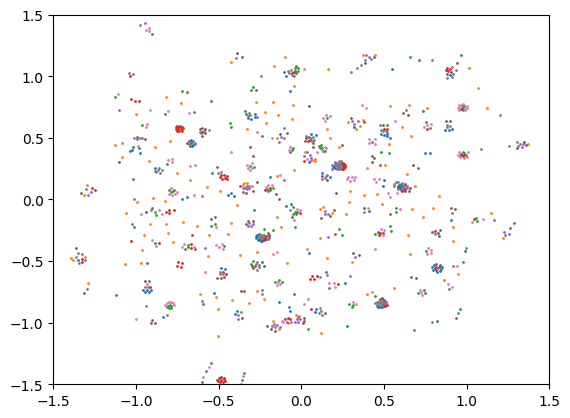

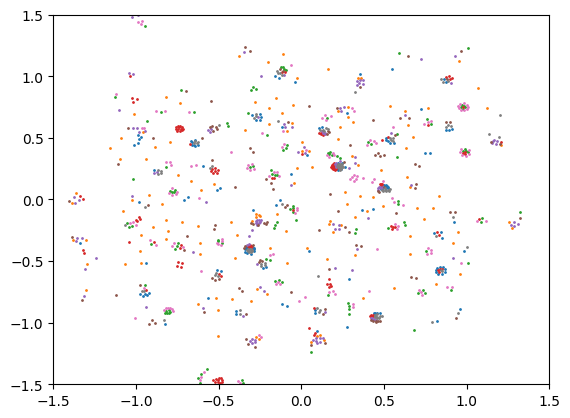

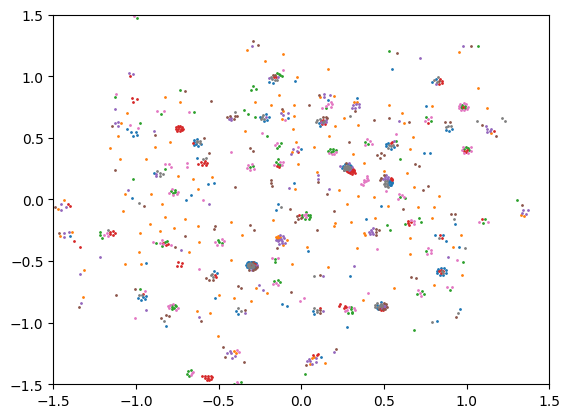

In [159]:
rng = jax.random.PRNGKey(1)

rng, _rng = split(rng)
env_params = init_env_params(_rng)
rng, _rng = split(rng)
state = init_state(_rng)

for i in tqdm(range(1000)):
    rng, _rng = split(rng)
    state = forward_state(_rng, state, env_params)
    if i % 100 == 0:
        render_state(state)
        plt.show()
    

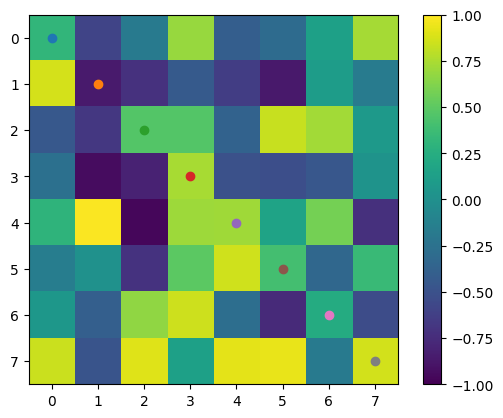

In [160]:
plt.imshow(env_params['alphas'], vmin=-1, vmax=1)
plt.colorbar()
for i in range(n_colors):
    plt.scatter(i, i)

In [ ]:
# todo make into torus
